In [1]:
import os
import pandas as pd
from pathlib import Path
from datetime import datetime
from sklearn.impute import KNNImputer
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn

In [2]:
BASE_DIR = Path("Cash Data January 2021")

In [3]:
tickers = [i.rsplit(".", maxsplit=1)[0] for i in os.listdir(BASE_DIR)]
tickers[:10]

['.CNX100',
 '.CNXIT',
 '.NSEBANK',
 '.NSEI',
 '20MICRONS',
 '21STCENMGM',
 '3IINFOTECH',
 '3MINDIA',
 '3PLAND',
 '5PAISA']

In [4]:


def get_stock_data(
    tickers,
    start=None,
    end=None,
    agg_func=None,
    resample_freq=None,
    columns=None,
    impute=True
):
    data_dict = {}
    start = pd.to_datetime(start)
    end = pd.to_datetime(end)

    for ticker in tickers:
        df = pd.read_csv(Path(BASE_DIR) / f"{ticker}.csv")
        df.columns = [col.strip('<> ').strip() for col in df.columns]
        df["datetime"] = pd.to_datetime(df["date"] + " " + df["time"], format="%m/%d/%Y %H:%M:%S")
        df = df.rename(columns={"o/i": "open_interest"})
        df = df.drop(columns=["ticker", "date", "time"], errors="ignore")
        df = df.set_index("datetime")
        df = df.sort_index()

            
        if resample_freq:
            impute = True

        if columns:
            df = df[columns]
        if impute:    

            full_index = pd.date_range(start=df.index.min(), end=df.index.max(), freq="1min")
            df = df.reindex(full_index)
            for col in df.columns:
               df[col] = df[col].fillna(df[col].expanding().median())
        if start:
            df = df[df.index >= start]
        if end:
            df = df[df.index <= end]
        

        if resample_freq:
            if agg_func is None:
                raise ValueError("agg_func must be provided when resampling.")
            df = df.resample(resample_freq).agg(agg_func)

        data_dict[ticker] = df

    return data_dict


In [5]:
dfs = get_stock_data(
    tickers,
    impute=False
)

Mean trading volume for all the stocks for the month

In [6]:
overall_mean_monthly_traded_volume = sum(df.volume.mean() for _, df in dfs.items())/len(dfs)

 Here we find the stocks whichh have high trading mean trading volumes for atleast half the month

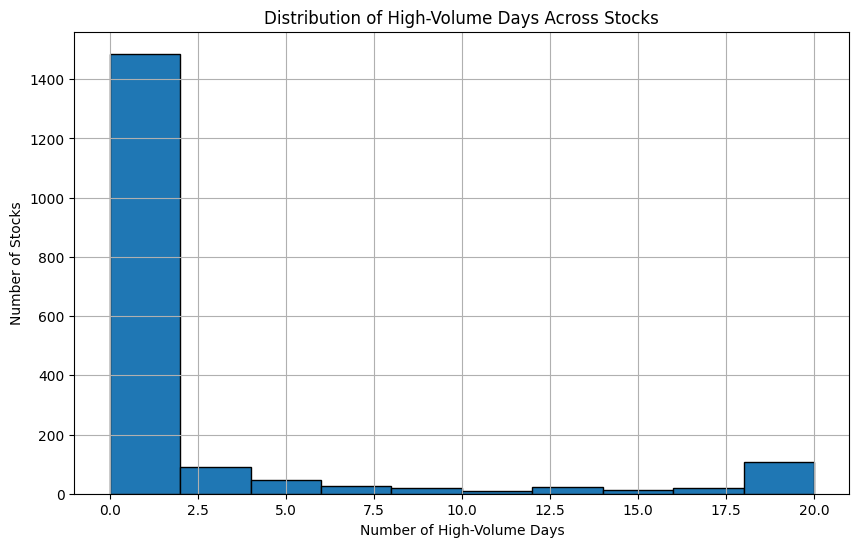

In [7]:
import matplotlib.pyplot as plt

# Calculate high volume day count for each stock
high_volume_day_counts = {
    s: (df.groupby(df.index.date)['volume'].mean() > overall_mean_monthly_traded_volume).sum().item()
    for s, df in dfs.items()
}

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(high_volume_day_counts.values(), bins=10, edgecolor='black')
plt.xlabel('Number of High-Volume Days')
plt.ylabel('Number of Stocks')
plt.title('Distribution of High-Volume Days Across Stocks')
plt.grid(True)
plt.show()


We observe that for more than half of January, there was sufficient liquidity in the market for some of the stocks. A huge number of stocks have been illiquid 

In [8]:
liquid_stocks = [ s for s, v in high_volume_day_counts.items() if v > 15]

In [9]:
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant

def calculate_half_life(price_series):
    delta_p = price_series.diff().dropna()
    p_lag = price_series.shift(1).dropna()
    
    # Align indices explicitly - keep only indices that appear in both
    common_idx = delta_p.index.intersection(p_lag.index)
    delta_p = delta_p.loc[common_idx]
    p_lag = p_lag.loc[common_idx]
    
    model = OLS(delta_p.values, add_constant(p_lag.values))
    res = model.fit()
    beta = res.params[1]
    halflife = -np.log(2) / beta if beta < 0 else np.inf
    return halflife

def hurst_exponent(ts):
    lags = range(2, 100)
    tau = [np.sqrt(np.std(np.subtract(ts[lag:], ts[:-lag]))) for lag in lags]
    poly = np.polyfit(np.log(lags), np.log(tau), 1)
    return poly[0] * 2.0

def mean_reversion_vector(price_series):
    price_series = price_series.dropna()
    
    adf_stat = adfuller(price_series)[0]
    half_life = calculate_half_life(price_series)
    hurst = hurst_exponent(price_series.values)
    
    returns = price_series.pct_change().dropna()
    vol = returns.std()
    
    return np.array([adf_stat, half_life, hurst, vol])

# Now your embedding extraction code can stay the same:
embedding_list = []
valid_stocks = []

for ticker in liquid_stocks:
    df = dfs[ticker]
    price_series = df['close']
    
    try:
        vec = mean_reversion_vector(price_series)
        if np.all(np.isfinite(vec)):
            embedding_list.append(vec)
            valid_stocks.append(ticker)
    except Exception as e:
        print(f"Failed for {ticker}: {e}")

embeddings = np.vstack(embedding_list)


In [10]:
embedding_list = []
valid_stocks = []

for ticker in liquid_stocks:
    df = dfs[ticker]
    price_series = df['close']  # Or your adjusted close column
    
    try:
        vec = mean_reversion_vector(price_series)
        if np.all(np.isfinite(vec)):
            embedding_list.append(vec)
            valid_stocks.append(ticker)
    except Exception as e:
        print(f"Failed for {ticker}: {e}")

embeddings = np.vstack(embedding_list)


In [11]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import AgglomerativeClustering

# Cosine similarity matrix
cos_sim = cosine_similarity(embeddings)

# Cluster - for example, hierarchical clustering
cluster_model = AgglomerativeClustering(n_clusters=5, linkage='average')
# Note AgglomerativeClustering expects a distance matrix, so convert similarity -> distance
distances = 1 - cos_sim
labels = cluster_model.fit_predict(distances)

# Now labels[i] gives cluster of valid_stocks[i]


   ---------------------------------------- 0.0/2.8 MB ? eta -:--:--
   ------------------------- -------------- 1.8/2.8 MB 9.2 MB/s eta 0:00:01
   ---------------------------------------- 2.8/2.8 MB 8.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/30.3 MB ? eta -:--:--
   -- ------------------------------------- 1.8/30.3 MB 9.0 MB/s eta 0:00:04
   ---- ----------------------------------- 3.4/30.3 MB 8.8 MB/s eta 0:00:04
   ------ --------------------------------- 4.7/30.3 MB 7.9 MB/s eta 0:00:04
   -------- ------------------------------- 6.8/30.3 MB 8.3 MB/s eta 0:00:03
   ----------- ---------------------------- 8.9/30.3 MB 8.5 MB/s eta 0:00:03
   -------------- ------------------------- 10.7/30.3 MB 8.4 MB/s eta 0:00:03
   ---------------- ----------------------- 12.6/30.3 MB 8.4 MB/s eta 0:00:03
   ------------------ --------------------- 14.2/30.3 MB 8.4 MB/s eta 0:00:02
   -------------------- ------------------- 15.7/30.3 MB 8.2 MB/s eta 0:00:02
   ---------


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip
C:\Users\mangl\Desktop\wqu\venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


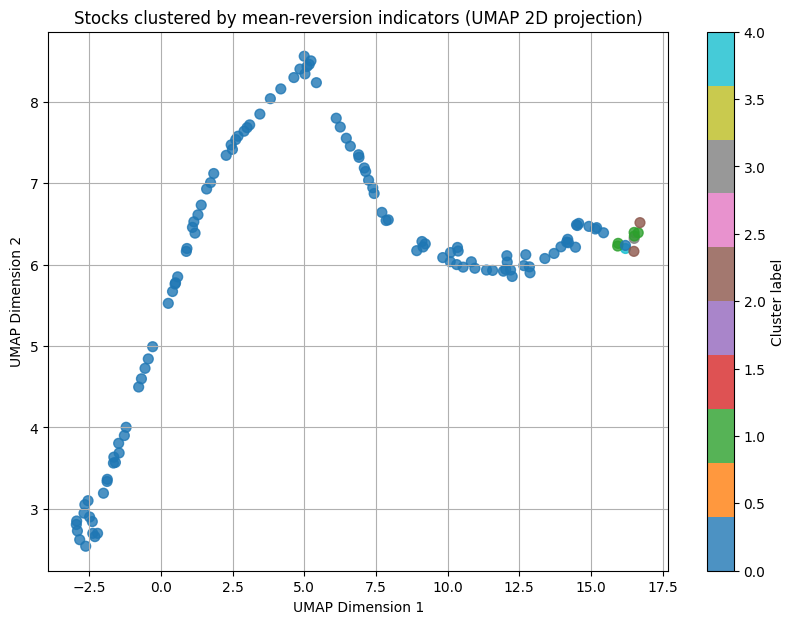

In [13]:
! pip install umap-learn

import umap.umap_ as umap

reducer = umap.UMAP(n_components=2, random_state=42)
embeddings_umap = reducer.fit_transform(embeddings)

plt.figure(figsize=(10, 7))
scatter = plt.scatter(embeddings_umap[:, 0], embeddings_umap[:, 1], c=labels, cmap='tab10', s=50, alpha=0.8)
plt.title("Stocks clustered by mean-reversion indicators (UMAP 2D projection)")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.colorbar(scatter, label='Cluster label')
plt.grid(True)
plt.show()
